In [ ]:
import pandas as pd
import numpy as np
import nltk
from sklearn.preprocessing import MultiLabelBinarizer
import tensorflow_hub as hub
import tensorflow_text as text
import tensorflow as tf
from sklearn.model_selection import train_test_split

data = pd.read_csv("../data/goodreads_data.csv").drop("Unnamed: 0", axis=1)


# Preprocess the data
data = data.dropna()
data = data.drop_duplicates()

In [131]:
!pip install tensorflow_addons

ERROR: Could not find a version that satisfies the requirement tensorflow_addons (from versions: none)
ERROR: No matching distribution found for tensorflow_addons


In [133]:
import os
import re
import string
import json
import numpy as np
import pandas as pd
from sklearn import metrics
from bs4 import BeautifulSoup
import transformers
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, AutoTokenizer, BertModel, BertConfig, AutoModel
import warnings
warnings.filterwarnings('ignore')

In [134]:
data.head()

Book         Author  \
0                              To Kill a Mockingbird     Harper Lee   
1  Harry Potter and the Philosopher’s Stone (Harr...   J.K. Rowling   
2                                Pride and Prejudice    Jane Austen   
3                          The Diary of a Young Girl     Anne Frank   
4                                        Animal Farm  George Orwell   

                                         Description  \
0  The unforgettable novel of a childhood in a sl...   
1  Harry Potter thinks he is an ordinary boy - un...   
2  Since its immediate success in 1813, Pride and...   
3  Discovered in the attic in which she spent the...   
4  Librarian's note: There is an Alternate Cover ...   

                                              Genres  Avg_Rating Num_Ratings  \
0  ['Classics', 'Fiction', 'Historical Fiction', ...        4.27   5,691,311   
1  ['Fantasy', 'Fiction', 'Young Adult', 'Magic',...        4.47   9,278,135   
2  ['Classics', 'Fiction', 'Romance', 'Historical...        4.28   3,944,155   
3  ['Classics', 'Nonfiction', 'History', 'Biograp...        4.18   3,488,438   
4  ['Classics', 'Fiction', 'Dystopia', 'Fantasy',...        3.98   3,575,172   

                                                 URL  
0  https://www.goodreads.com/book/show/2657.To_Ki...  
1  https://www.goodreads.com/book/show/72193.Harr...  
2  https://www.goodreads.com/book/show/1885.Pride...  
3  https://www.goodreads.com/book/show/48855.The_...  
4  https://www.goodreads.com/book/show/170448.Ani...

In [135]:
#Extract all the distinct genres from the data
genre_set = set()
for s in data['Genres']:
    # Extracting genres from the string
    genres = [genre.strip(" '") for genre in s.strip("[]").split(",")]

    # Creating a set of genres
    genres = set(genres)
    genre_set.update(genres)

genre_set.remove('')

print(len(genre_set)) #gives 617

#Getting count of each genre in the data
genre_list = list()
for s in data['Genres']:
    # Extracting genres from the string
    genres = [genre.strip(" '") for genre in s.strip("[]").split(",")]

    genre_list.extend(genres)

from collections import Counter
genres_count = dict(Counter(genre_list))

genres_count_sorted = {k: v for k, v in sorted(genres_count.items(), key=lambda item: item[1],
                                              reverse=True)}

617


In [136]:
#checking if there are any repetitions of any genre in upper and lower cases
len({x.lower() for x in genre_set})

617

In [137]:
import statistics
counts = list(genres_count.values())
print(max(counts))
print(min(counts))
print(sum(counts)/len(counts))
print(statistics.median(counts))

#average frequency of each genre is around 95
top_genres = {k:v for k, v in genres_count.items() if v>=95}
print(len(top_genres)) #gives 100

top_genres = list(genres_count_sorted.keys())[:5] #taking top 5 genres for avoiding sparsity problem during model training

5686
1
95.08414239482201
10.0
100


In [138]:
top_genres

['Fiction', 'Nonfiction', 'Fantasy', 'Classics', 'Romance']

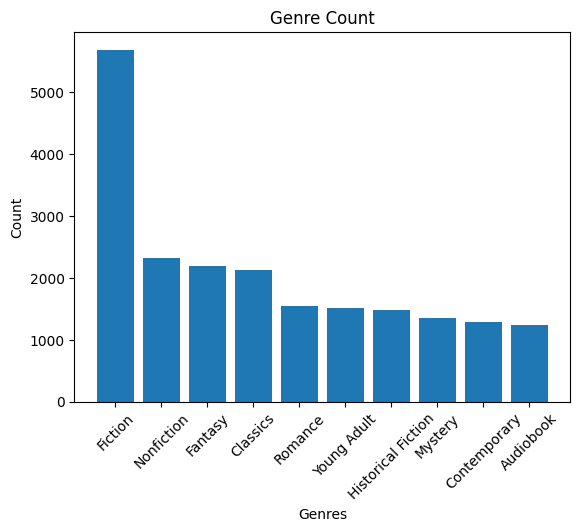

In [139]:
##Plotting frequencies of top 10 genres

import matplotlib.pyplot as plt
# Extracting the top 10 genres and their corresponding counts
genres = list(genres_count_sorted.keys())[:10]
counts = list(genres_count_sorted.values())[:10]
# Creating a bar plot
plt.bar(genres, counts)
# Adding labels and title
plt.xlabel('Genres')
plt.ylabel('Count')
plt.title('Genre Count')
# Rotating the x-axis labels for better readability (optional)
plt.xticks(rotation=45)
# Displaying the plot
plt.show()

In [140]:
##Check length of genres list for each row

genres_length = set()
for s in data['Genres']:
    # Extracting genres from the string
    genres = [genre.strip(" '") for genre in s.strip("[]").split(",")]

    # Creating a set of genres
    length = len(genres)
    genres_length.add(length)

print(genres_length) #gives {1,2,3,4,5,6,7}

{1, 2, 3, 4, 5, 6, 7}


In [141]:
df = data.copy()
df = df[['Description', 'Genres']]

In [142]:
#['Fiction', 'Nonfiction', 'Fantasy', 'Classics', 'Romance']

is_fiction = list()
is_nonfiction = list()
is_fantasy = list()
is_classics = list()
is_romance = list()

def make_genre_map_list(genres, listname, genrename):
    if genrename in genres:
        listname.append(1)
    else:
        listname.append(0)

for s in df['Genres']:
    # Extracting genres from the string
    genres = [genre.strip(" '") for genre in s.strip("[]").split(",")]

    make_genre_map_list(genres, is_fiction, 'Fiction')
    make_genre_map_list(genres, is_nonfiction, 'Nonfiction')
    make_genre_map_list(genres, is_fantasy, 'Fantasy')
    make_genre_map_list(genres, is_classics, 'Classics')
    make_genre_map_list(genres, is_romance, 'Romance')




In [143]:
df['is_fiction'] = is_fiction
df['is_nonfiction'] = is_nonfiction
df['is_fantasy'] = is_fantasy
df['is_classics'] = is_classics
df['is_romance'] = is_romance

In [144]:
df.head()

Description  \
0  The unforgettable novel of a childhood in a sl...   
1  Harry Potter thinks he is an ordinary boy - un...   
2  Since its immediate success in 1813, Pride and...   
3  Discovered in the attic in which she spent the...   
4  Librarian's note: There is an Alternate Cover ...   

                                              Genres  is_fiction  \
0  ['Classics', 'Fiction', 'Historical Fiction', ...           1   
1  ['Fantasy', 'Fiction', 'Young Adult', 'Magic',...           1   
2  ['Classics', 'Fiction', 'Romance', 'Historical...           1   
3  ['Classics', 'Nonfiction', 'History', 'Biograp...           0   
4  ['Classics', 'Fiction', 'Dystopia', 'Fantasy',...           1   

   is_nonfiction  is_fantasy  is_classics  is_romance  
0              0           0            1           0  
1              0           1            1           0  
2              0           0            1           1  
3              1           0            1           0  
4              0           1            1           0

In [145]:
y = df.drop(['Description', 'Genres'], axis=1)
x_train, x_test, y_train, y_test = train_test_split(data['Description'], y, test_size=0.20)

In [146]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [147]:
!pip install keras

In [148]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import pandas as pd

# Загружаем необходимые ресурсы для английского языка
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

# Функция для предобработки текста
def preprocess(text, punctuation_marks, stop_words, lemmatizer):
    tokens = word_tokenize(text.lower())  # Токенизируем текст и приводим к нижнему регистру
    preprocessed_text = []

    for token in tokens:
        if token not in punctuation_marks:  # Игнорируем знаки препинания
            lemma = lemmatizer.lemmatize(token)  # Лемматизация
            if lemma not in stop_words:  # Если лемма не является стоп-словом
                preprocessed_text.append(lemma)  # Добавляем лемму в список

    return ' '.join(preprocessed_text)  # Возвращаем предобработанный текст в виде строки

# Задание параметров для английского языка
punctuation_marks = ['!', '.', ',', '?', ':', ';', '-', '(', ')', '[', ']', '"', "'",'that', 'this', "it's", 'would', 'should', 'could', 'we', 'you', 'he', 'she', 'it', 'they', 'the', 'a', 'an', 'for', 'on', 'and', 'or', 'but', 'is', 'are', 'was', 'were', 'been', 'being', 'to', 'with', 'of', 'in', 'at', 'by', 'as', 'from', 'about']
stop_words = stopwords.words('english')  # Стоп-слова для английского языка
lemmatizer = WordNetLemmatizer()

# Предположим, что у тебя есть DataFrame 'df' с колонкой 'Description'
# Пример: df = pd.read_csv('your_file.csv')

# Применяем функцию к каждому тексту в колонке 'Description'
df['processed_description'] = df['Description'].apply(lambda row: preprocess(row, punctuation_marks, stop_words, lemmatizer))

# Выводим несколько примеров предобработанных текстов
print(df['processed_description'].head())


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


0    unforgettable novel childhood sleepy southern ...
1    harry potter think ordinary boy rescued owl ta...
2    since immediate success 1813 pride prejudice h...
3    discovered attic spent last year life anne fra...
4    librarian 's note alternate cover edition edit...
Name: processed_description, dtype: object


In [149]:
!pip install langdetect

In [152]:
from tensorflow.keras.preprocessing.text import Tokenizer
import pandas as pd

# Загружаем DataFrame
# Пример:
# df = pd.read_csv('your_file.csv')

# Предположим, что у тебя есть колонка 'Description'
comments = df['processed_description']

# 1. Создание токенизатора
num_words = 10000  # Максимальное количество слов в словаре
tokenizer = Tokenizer(num_words=num_words)

# 2. Обучение токенизатора на колонке 'Description'
tokenizer.fit_on_texts(comments)

# 3. Просмотр словаря токенизатора
print(tokenizer.word_index)  # Покажет словарь с индексами для каждого слова

# 4. Преобразуем описание в числовое представление
sequences = tokenizer.texts_to_sequences(comments)

# 5. Пример вывода для одного комментария
index = 1  # Например, выводим второй комментарий
print(f"Original text: {comments.iloc[index]}")
print(f"Text in sequence form: {sequences[index]}")

# 6. Получаем числовое представление для всех комментариев
X = sequences

# (Если необходимо, можно дополнительно паддировать данные для использования в нейронных сетях)
from keras.preprocessing.sequence import pad_sequences

# Паддирование, чтобы все последовательности имели одинаковую длину
X_padded = pad_sequences(X, padding='post', maxlen=50)  # maxlen — максимальная длина последовательности

# Пример: выводим первые несколько строк
print(X)


{"'s": 1, '’': 2, 'life': 3, 'ha': 4, 'one': 5, 'world': 6, 'book': 7, 'story': 8, 'new': 9, "''": 10, 'year': 11, 'time': 12, 'love': 13, 'find': 14, 'first': 15, 'family': 16, 'way': 17, 'man': 18, 'novel': 19, 'woman': 20, 'people': 21, 'two': 22, 'work': 23, 'make': 24, '”': 25, '“': 26, 'u': 27, 'young': 28, 'take': 29, 'war': 30, 'old': 31, 'like': 32, "n't": 33, 'day': 34, 'author': 35, 'know': 36, 'secret': 37, 'friend': 38, 'even': 39, 'child': 40, 'come': 41, 'human': 42, 'never': 43, 'reader': 44, 'must': 45, 'power': 46, 'de': 47, 'ever': 48, 'also': 49, 'thing': 50, 'get': 51, 'help': 52, 'heart': 53, 'best': 54, 'death': 55, 'back': 56, 'father': 57, 'home': 58, 'history': 59, 'girl': 60, 'want': 61, 'past': 62, 'many': 63, 'tale': 64, 'mother': 65, 'american': 66, 'every': 67, 'long': 68, 'great': 69, 'go': 70, 'set': 71, 'change': 72, 'well': 73, 'three': 74, 'journey': 75, 'god': 76, 'place': 77, 'end': 78, 'the': 79, 'become': 80, 'doe': 81, 'begin': 82, 'boy': 83, 'c

In [153]:
from sklearn.decomposition import PCA

# Применяем PCA для снижения размерности (ограничиваем до минимального числа признаков)
n_components = min(100, X_padded.shape[1])  # n_components не может быть больше числа признаков
pca = PCA(n_components=n_components)

# Применяем PCA
X_pca = pca.fit_transform(X_padded)

# Размерность после PCA
print(f"Размерность данных после PCA: {X_pca.shape}")


Размерность данных после PCA: (9923, 50)


In [154]:
y = df[['is_fiction', 'is_nonfiction', 'is_fantasy', 'is_classics', 'is_romance']]
print(y)

      is_fiction  is_nonfiction  is_fantasy  is_classics  is_romance
0              1              0           0            1           0
1              1              0           1            1           0
2              1              0           0            1           1
3              0              1           0            1           0
4              1              0           1            1           0
...          ...            ...         ...          ...         ...
9995           0              0           1            0           0
9996           0              0           0            0           0
9997           1              0           0            0           0
9998           0              0           0            0           1
9999           0              0           0            0           0

[9923 rows x 5 columns]


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import time

# Задаем X и y
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

# Список моделей для многоклассовой классификации
models = [
    LogisticRegression(),
    RandomForestClassifier(),
    KNeighborsClassifier(),
    SVC(),
    DecisionTreeClassifier(),
    GradientBoostingClassifier(),
    AdaBoostClassifier(),
    GaussianNB()
]

# Создаем список для хранения результатов
results = []

# Обучение моделей, вычисление точности и времени
for model in models:
    start_time = time.time()  # Засекаем время до начала обучения

    # Используем MultiOutputClassifier для многоклассовой классификации
    multi_target_model = MultiOutputClassifier(model, n_jobs=-1)

    # Обучаем модель
    multi_target_model.fit(X_train, y_train)

    # Предсказания
    y_pred = multi_target_model.predict(X_test)

    end_time = time.time()  # Засекаем время после выполнения

    # Рассчитываем точность
    accuracy = accuracy_score(y_test, y_pred)

    # Рассчитываем время работы
    duration = end_time - start_time

    results.append({
        'Model': model.__class__.__name__,
        'Accuracy': accuracy,
        'Time (s)': duration
    })

    # Строим матрицу ошибок
    # Строим матрицу ошибок
    # Строим матрицу ошибок
    cm = confusion_matrix(y_test.to_numpy().argmax(axis=1), y_pred.argmax(axis=1))  # Преобразуем в массив numpy и применяем argmax

# Указываем правильные метки для категорий
    labels = ['is_fiction', 'is_nonfiction', 'is_fantasy', 'is_classics', 'is_romance']

# Создаем объект для отображения матрицы ошибок
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

# Отображаем матрицу ошибок
    disp.plot(cmap='Blues')
    plt.title(f'Confusion Matrix for {model.__class__.__name__}')
    plt.show()



# Преобразуем результаты в DataFrame
import pandas as pd
results_df = pd.DataFrame(results)

# Отображаем таблицу с результатами
results_df


MOVE TO NEURAL NETWORKS


In [155]:
# Проверяем максимальный индекс в X_train
max_index = np.max(X_train)
print(f"Максимальный индекс в X_train: {max_index}")


Максимальный индекс в X_train: 30754.783977334664


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


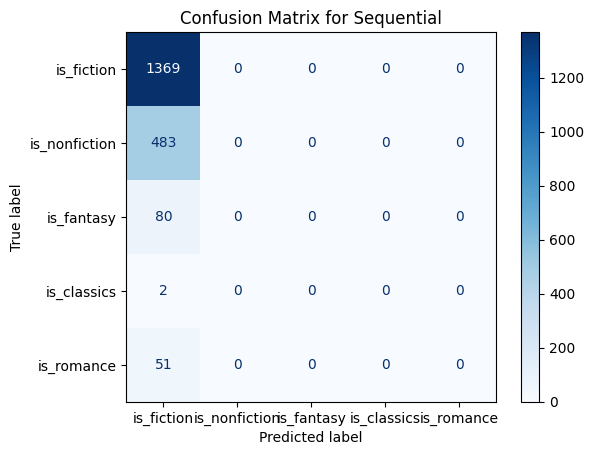

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


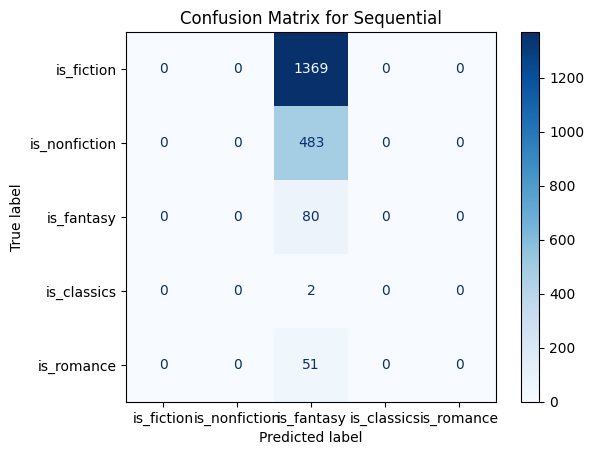

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import PCA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, SimpleRNN, Embedding, Flatten
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.sequence import pad_sequences
import time


# 1. Многослойный перцептрон (MLP)
model_mlp = Sequential([
    Dense(512, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(5, activation='softmax')  # 5 выходов для многоклассовой классификации
])

# 2. Сверточная нейронная сеть (CNN)
# Увеличиваем input_dim для слоя Embedding
model_cnn = Sequential([
    Embedding(input_dim=30755, output_dim=128, input_length=X_train.shape[1]),
    Conv1D(128, 5, activation='relu'),
    MaxPooling1D(pool_size=4),
    Conv1D(128, 5, activation='relu'),
    MaxPooling1D(pool_size=4),
    Flatten(),
    Dense(5, activation='softmax')  # 5 выходов для многоклассовой классификации
])


# 3. Рекуррентная нейронная сеть (RNN)
model_rnn = Sequential([
    Embedding(input_dim=30755, output_dim=128, input_length=X_train.shape[1]),
    SimpleRNN(128, activation='relu'),
    Dropout(0.5),
    Dense(5, activation='softmax')  # 5 выходов
])

# 4. Автокодировщик (Autoencoder)
input_dim = X_train.shape[1]
autoencoder = Sequential([
    Dense(128, activation='relu', input_shape=(input_dim,)),
    Dropout(0.5),
    Dense(input_dim, activation='sigmoid')  # Восстановление данных
])

# Список моделей
models = [model_mlp, model_cnn, model_rnn, autoencoder]

# Список для хранения результатов
results = []

# Обучение моделей, вычисление точности и времени
for model in models:
    start_time = time.time()  # Засекаем время до начала обучения

    # Компиляция модели
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

    # Обучение модели
    model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)

    # Предсказания
    y_pred = model.predict(X_test)
    y_pred_classes = y_pred.argmax(axis=1)  # Преобразуем вероятности в классы

    end_time = time.time()  # Засекаем время после выполнения

    # Преобразуем y_test в numpy массив и применяем argmax
    accuracy = accuracy_score(y_test.to_numpy().argmax(axis=1), y_pred_classes)

    # Рассчитываем время работы
    duration = end_time - start_time

    results.append({
        'Model': model.__class__.__name__,
        'Accuracy': accuracy,
        'Time (s)': duration
    })

    # Строим матрицу ошибок
    cm = confusion_matrix(y_test.to_numpy().argmax(axis=1), y_pred_classes)  # Преобразуем в массив numpy и применяем argmax

    # Создаем объект для отображения матрицы ошибок
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

    # Отображаем матрицу ошибок
    disp.plot(cmap='Blues')
    plt.title(f'Confusion Matrix for {model.__class__.__name__}')
    plt.show()

# Преобразуем результаты в DataFrame
results_df = pd.DataFrame(results)

# Отображаем таблицу с результатами
print(results_df)

# Применение PCA для снижения размерности данных
pca = PCA(n_components=100)  # Выбираем количество компонент, например, 100
X_pca = pca.fit_transform(X_test)  # Применяем PCA к тестовым данным

# Размерность после PCA
print(f"Размерность данных после PCA: {X_pca.shape}")

# Визуализация снижения размерности с помощью PCA
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=np.argmax(y_test, axis=1), cmap='viridis', alpha=0.5)
plt.colorbar()
plt.title("PCA: Visualization of Test Data")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()
